# Разведочный и предиктивный анализ данных

### Описание данных
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

### Импорт данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Mall_Customers.csv")

### Разведочный анализ

In [4]:
# Количество пропущенных значений
df.isna().sum()

CustomerID                 0
Genre                     19
Age                       20
Annual Income (k$)        20
Spending Score (1-100)     0
dtype: int64

In [46]:
# Строки с более, чем с 1 пропуском
df[df.isna().sum(axis=1)>1]

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
1,2,Male,NaN,NaN,81
46,47,Female,NaN,NaN,55
54,55,NaN,50.0,NaN,45
106,107,NaN,NaN,63.0,50
123,124,NaN,39.0,NaN,91


In [47]:
# Удалим их
df = df[df.isna().sum(axis=1)<2]

In [ ]:
# Датафрейм с описательной статистикой
def descr_features(data):
    features = data.dtypes.to_frame(name="data_type")# Тип даных в столбце
    features["n_NaN"] = data.isna().sum() # Количество пропущенных значений
    features["%NaN"] = round(features["n_NaN"] / len(data) * 100, 2) # Процент пропущенных значений
    features["nunique"] = data.nunique().values # Количество уникальных значений
    describe_df = data.describe(include="all").round(1).T.drop(columns=['unique']) # Делает стандартную описательную статистику: среднее, минимум, максимум, квартили
    features = pd.merge(features, describe_df.round(0),  how="left", left_index=True, right_index=True) # Информация describe()
    return features

In [49]:
descr_features(df)

,data_type,n_NaN,%NaN,nunique,count,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,int64,0,0.00,195,195.0,NaN,NaN,101.4,57.9,1.0,51.5,101.0,151.5,200.0
Genre,object,16,8.21,3,179,Female,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,float64,17,8.72,51,178.0,NaN,NaN,39.8,16.9,18.0,29.0,36.0,49.0,135.0
Annual Income (k$),float64,16,8.21,64,179.0,NaN,NaN,5646.5,74739.0,15.0,42.0,61.0,78.0,1000000.0
Spending Score (1-100),int64,0,0.00,83,195.0,NaN,NaN,49.8,25.9,1.0,33.0,50.0,72.5,99.0


In [50]:
# Значения признака Genre
df.Genre.value_counts()

Genre
Female     101
Male        76
Feemale      2
Name: count, dtype: int64

In [51]:
# Заменим неверное значение Feemale
df["Genre"] = df["Genre"].replace({"Feemale":"Female"})

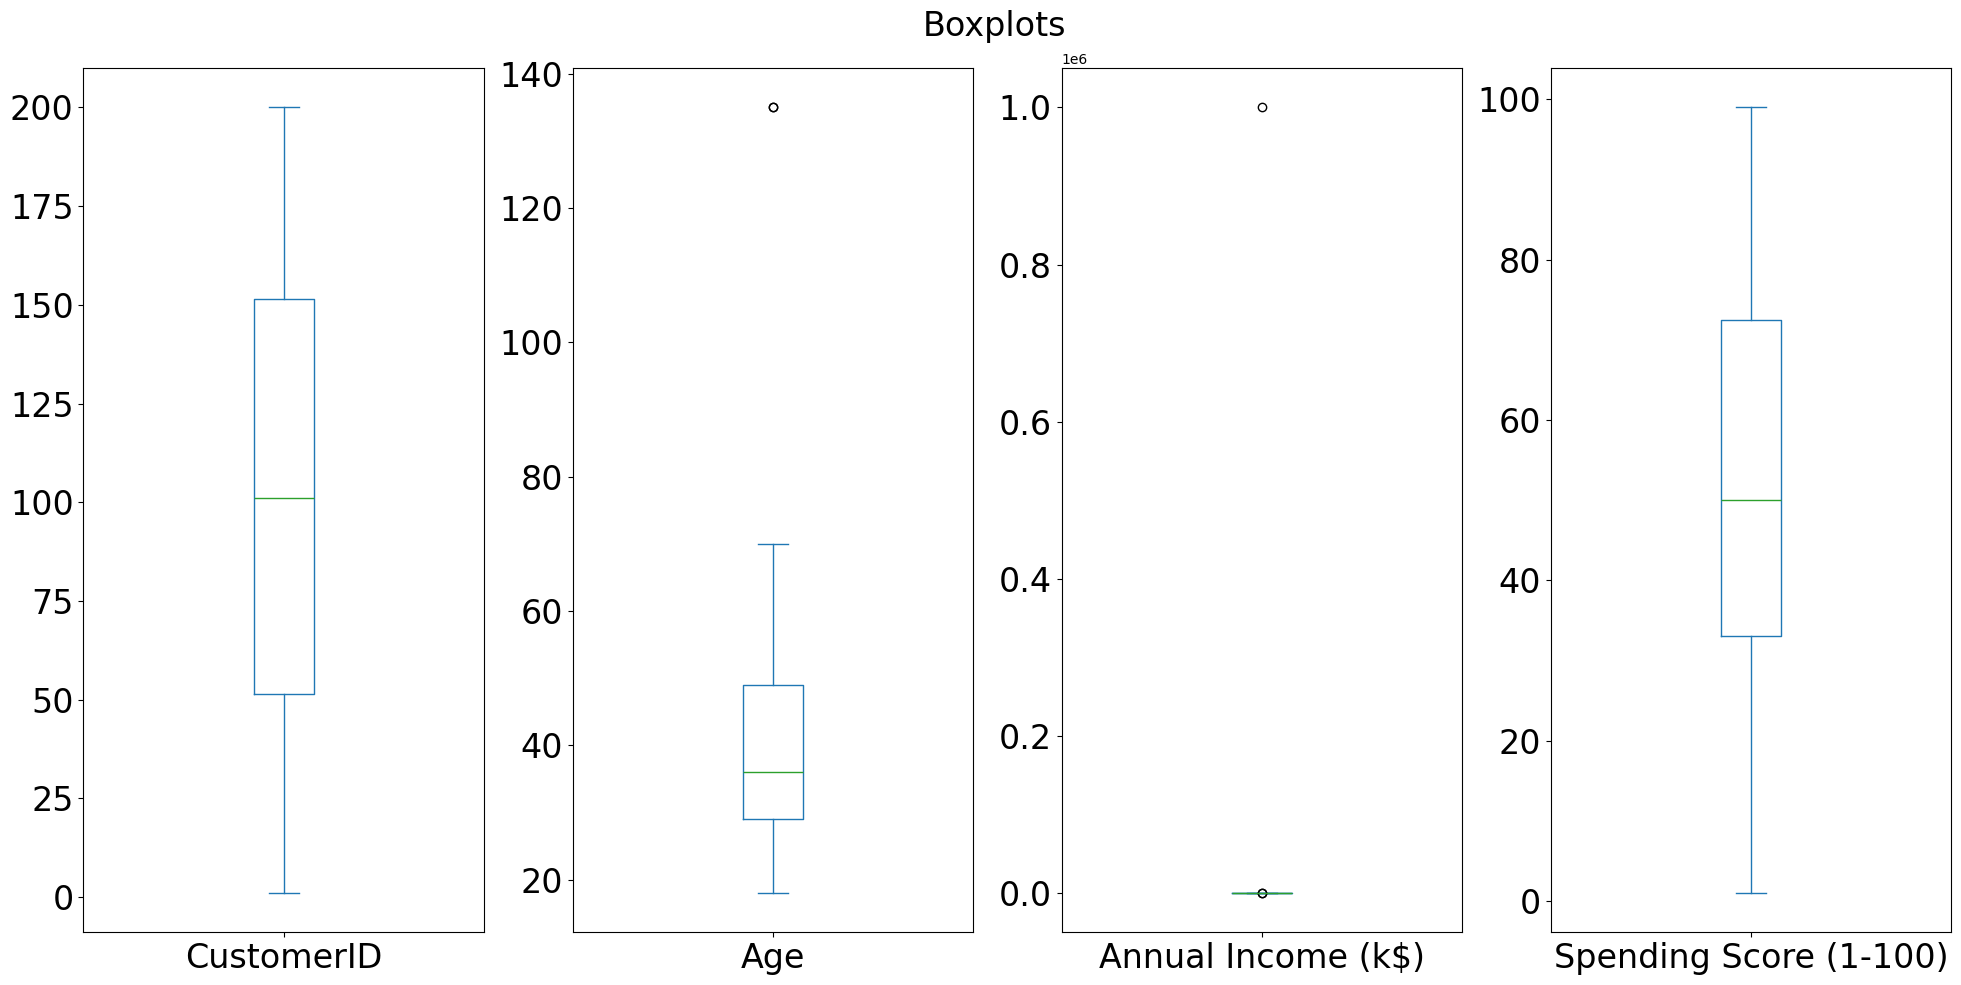

In [52]:
def get_boxplots(data: pd.DataFrame):
    # Числовые признаки
    num_features = data.drop(columns=["Genre"])
    
    # Boxplots
    ax = num_features.plot(kind="box", subplots=True, figsize=(20, 10), fontsize=24)
    plt.suptitle("Boxplots", fontsize=24, x=0.5)
    plt.tight_layout()
    plt.show()

get_boxplots(df)

В доходе и в возрасте присутствуют выбросы. При том для возраста это ошибочное значение (140 лет), а для дохода возможное.

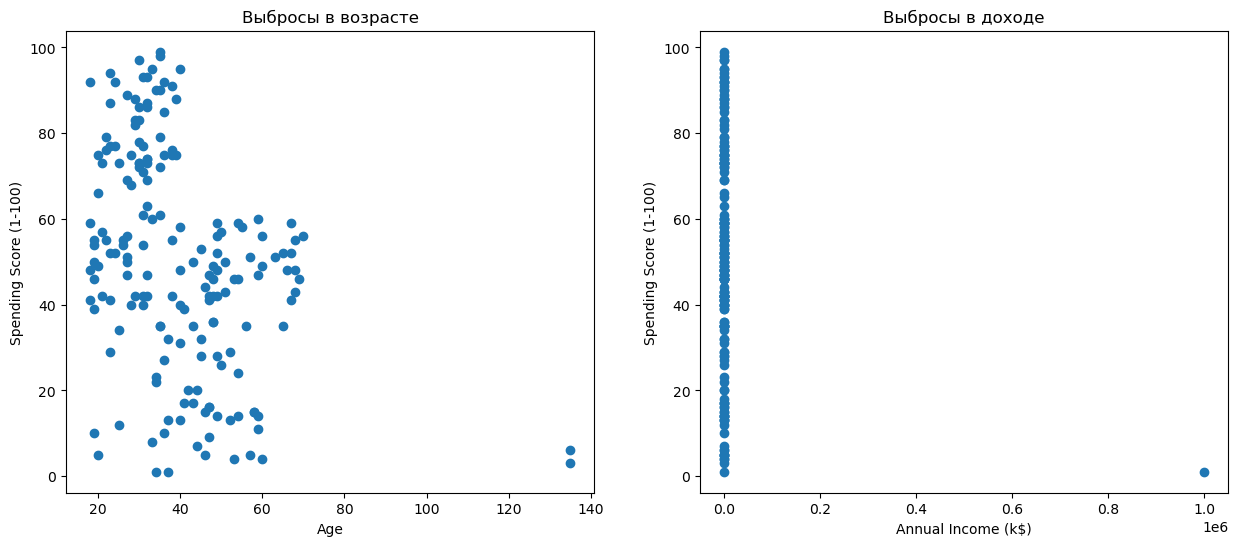

In [54]:
# Построим точечные графики 
plt.figure(figsize=(15,6));

plt.subplot(1, 2, 1)
plt.title("Выбросы в возрасте")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.scatter(df["Age"], df["Spending Score (1-100)"]);

plt.subplot(1, 2, 2)
plt.title("Выбросы в доходе")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.ylabel("Spending Score (1-100)")
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"]);

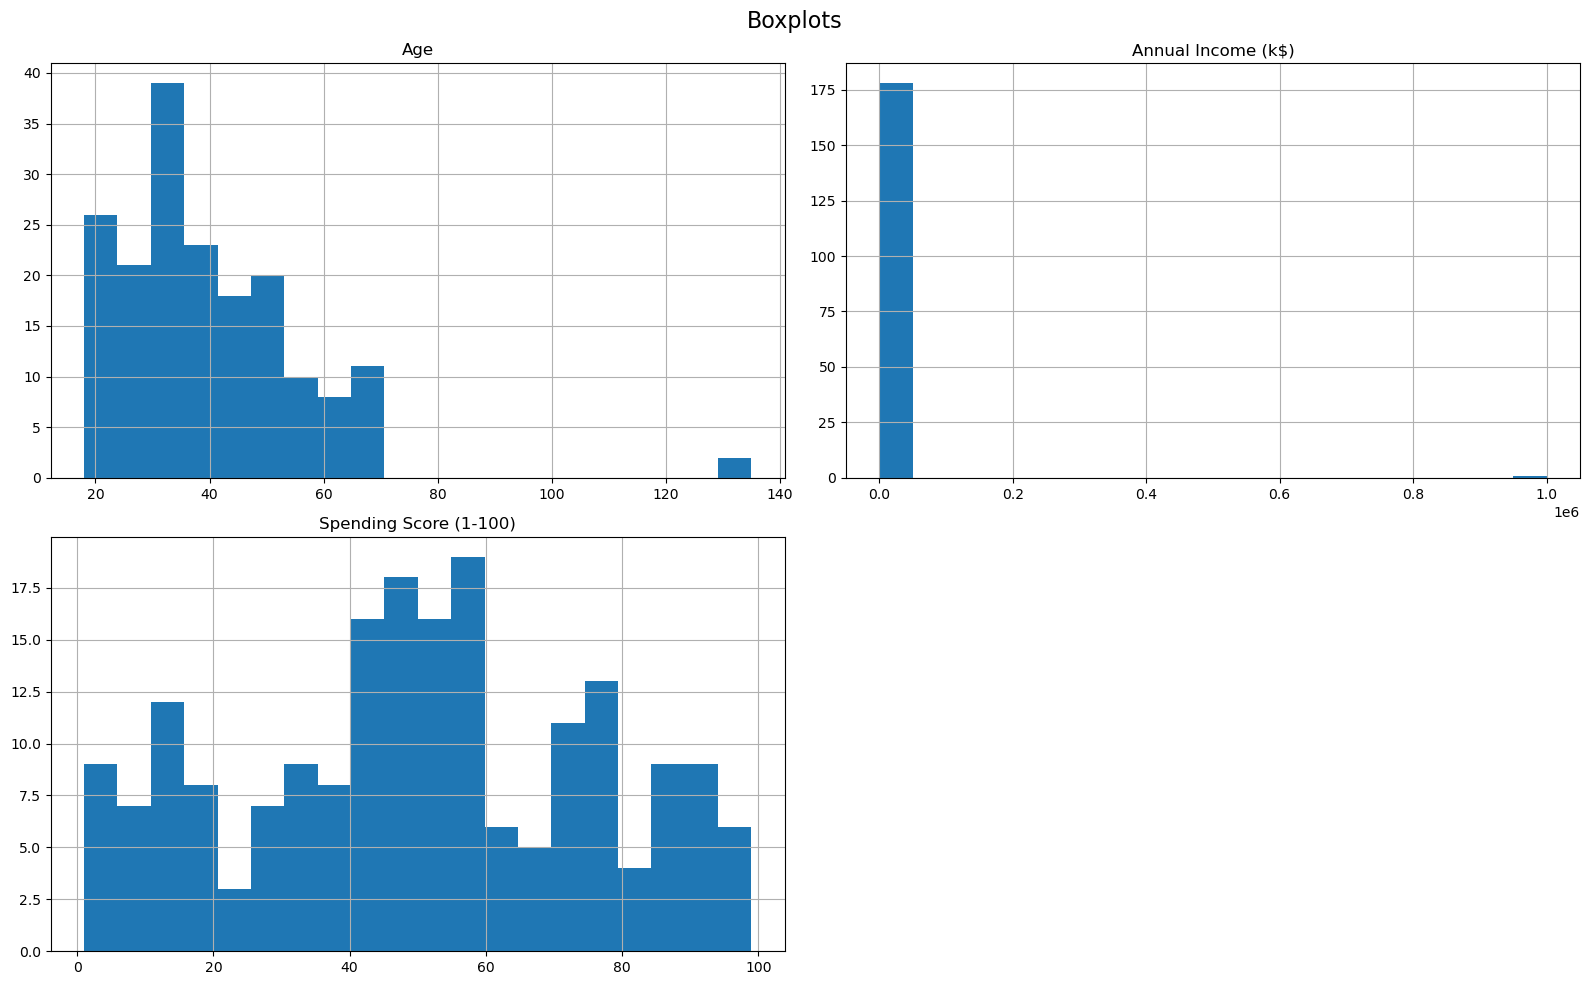

In [55]:
df.drop(columns=["CustomerID"]).hist(bins=20, figsize=(16, 10))
plt.suptitle("Boxplots", fontsize=16, x=0.5)
plt.tight_layout()
plt.show()

Признако возраста имеет распределение, близкое к нормальному. Для Spending Score видим несколько локальных максимумов. Оценить распределение дохода визуально не можем из-за аномального значения.

### Train test split

In [58]:
X = df.drop(columns=["Spending Score (1-100)", "CustomerID"])
y = df["Spending Score (1-100)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

### Обработка пропусков

In [60]:
df["Genre"].unique()

array(['Male', 'Female', nan], dtype=object)

In [61]:
# Заполняем пропущенные в категориальном признаке Genre модой
inp_median = SimpleImputer(strategy="most_frequent")
X_train["Genre"] = inp_median.fit_transform(X_train[["Genre"]])[:, 0]

In [62]:
# Заполняем пропущенные в доходе и возрасте значения с помощью метода ближайших соседей для более точной оценки
cols = ["Age", "Annual Income (k$)"]
inp_knn = KNNImputer(n_neighbors=3)
X_train[cols] = inp_knn.fit_transform(X_train[cols])

In [63]:
descr_features(X_train)

,data_type,n_NaN,%NaN,nunique,count,top,freq,mean,std,min,25%,50%,75%,max
Genre,object,0,0.0,2,156,Female,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,float64,0,0.0,58,156.0,NaN,NaN,39.8,17.0,18.0,29.8,36.0,48.0,135.0
Annual Income (k$),float64,0,0.0,67,156.0,NaN,NaN,6471.0,80059.2,15.0,44.0,62.0,78.0,1000000.0


Пропущеные значения обработаны

### Обработка выбросов


In [66]:
def get_bounds(df, column):
    q25 = df[column].quantile(0.25) # Рассчёт интерквартильного размаха
    q75 = df[column].quantile(0.75)
    iqr = q75 - q25
    bound = (q25 - iqr * 1.5, q75 + iqr * 1.5)
    out_of_bound = (df[column] > bound[1]) | (df[column] < bound[0])
    anom_count = df[column][out_of_bound].count()
    
    print("\033[1m",column,"\033[0m")
    print("Интерквартильный размах", bound)
    print(f"Диапазон значений: ({df[column].min()}; {df[column].max()})")
    print("Количество выбросов: ", anom_count)
    print("Их процент в выборке: ", anom_count / len(df) * 100, '\n')
    return out_of_bound

In [67]:
# Удаление выбросов
out_of_bounds = get_bounds(X_train, "Age")
X_train = X_train.drop(X_train[out_of_bounds].index)
out_of_bounds = get_bounds(X_train, "Annual Income (k$)")
X_train = X_train.drop(X_train[out_of_bounds].index)

 Age 
Интерквартильный размах (2.375, 75.375)
Диапазон значений: (18.0; 135.0)
Количество выбросов:  2
Их процент в выборке:  1.282051282051282 

 Annual Income (k$) 
Интерквартильный размах (-3.4583333333333215, 126.875)
Диапазон значений: (15.0; 1000000.0)
Количество выбросов:  3
Их процент в выборке:  1.948051948051948 



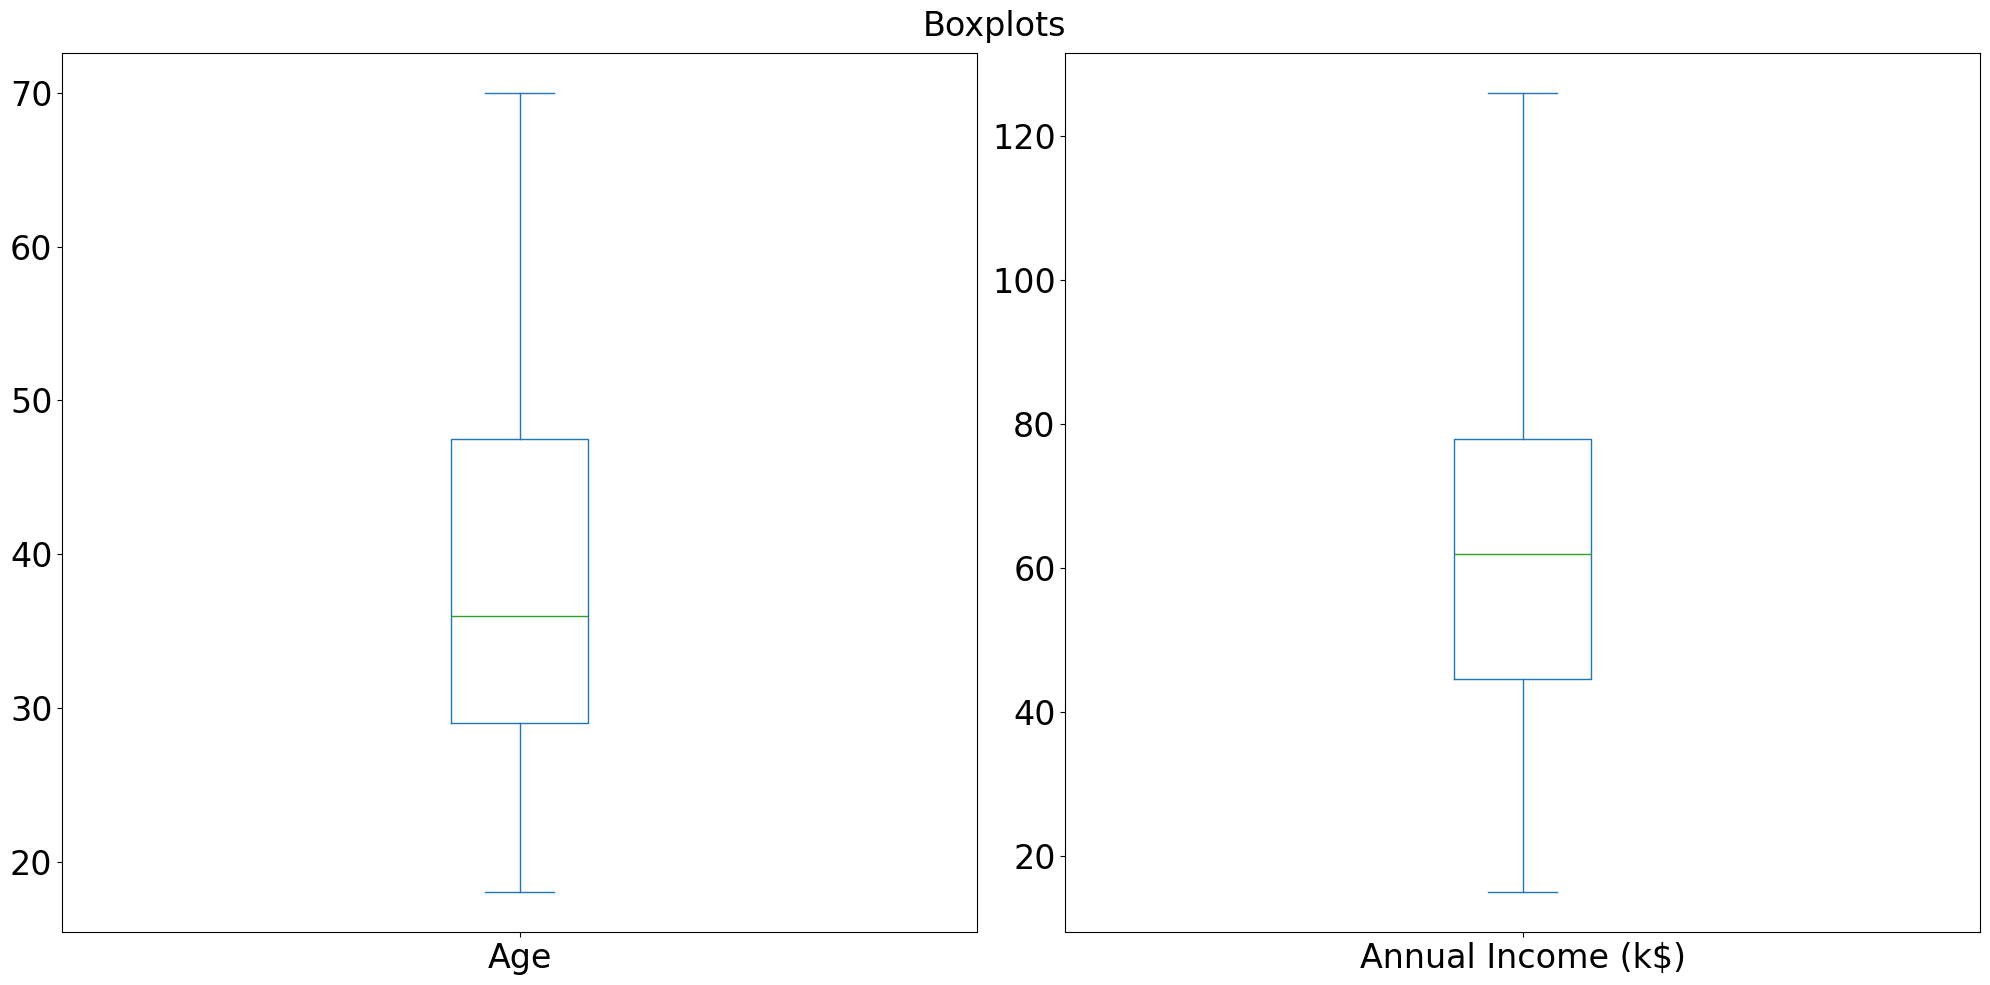

In [68]:
get_boxplots(X_train)

Для замены выбросов был применён меод расчёта интерквартильного размаха, так как процент выбросов очень мал.

### Создание новых признаков

In [119]:
# Отношение дохода к возрасту
X_train["Income_per_Age"] = X_train["Annual Income (k$)"] / X_train["Age"]
X_test["Income_per_Age"] = X_test["Annual Income (k$)"] / X_test["Age"]
# Отношение расходов к доходу
X_train["Spending_per_Income"] = y_train / X_train["Annual Income (k$)"]
X_test["Spending_per_Income"] = y_test / X_test["Annual Income (k$)"]

# Группы по возрасту и доходу
X_train["AgeGroup"] = pd.cut(X_train["Age"], bins=[0, 25, 45, 65, 100], labels=["Youth", "Adult", "Mid-age", "Senior"])
X_test["AgeGroup"] = pd.cut(X_test["Age"], bins=[0, 25, 45, 65, 100], labels=["Youth", "Adult", "Mid-age", "Senior"])
X_train["IncomeLevel"] = pd.qcut(X_train["Annual Income (k$)"], q=3, labels=["Low", "Medium", "High"])
X_test["IncomeLevel"] = pd.qcut(X_test["Annual Income (k$)"], q=3, labels=["Low", "Medium", "High"])

X_train.head()

,Genre,Age,Annual Income (k$),Income_per_Age,Spending_per_Income,AgeGroup,IncomeLevel
56,Female,51.0,44.0,0.862745,1.136364,Mid-age,Low
15,Male,22.0,20.0,0.909091,3.950000,Youth,Low
124,Female,23.0,70.0,3.043478,0.414286,Youth,Medium
20,Male,35.0,24.0,0.685714,1.458333,Adult,Low
49,Female,31.0,40.0,1.290323,1.050000,Adult,Low


In [121]:
num_vars = ["Annual Income (k$)", "Age", "Spending_per_Income", "Income_per_Age"]
cat_vars = ["Genre", "AgeGroup", "IncomeLevel"]

### Стандартизация


In [123]:
# Нормализуем признаки при помощи StandardScaler, так как диапозоны их значений разнятся
std_scaler = StandardScaler()
matrix = std_scaler.fit_transform(X_train[num_vars]) # Результат стандартизации 
names = [x + "_std" for x in num_vars] # Названия столбцов
X_train[names] = matrix 

In [124]:
X_train.drop(columns=num_vars, inplace=True)

In [125]:
X_train.head()

,Genre,AgeGroup,IncomeLevel,Annual Income (k$)_std,Age_std,Spending_per_Income_std,Income_per_Age_std
56,Female,Mid-age,Low,-0.700515,0.936584,0.115646,-1.012220
15,Male,Youth,Low,-1.706591,-1.266442,3.240276,-0.959013
124,Female,Youth,Medium,0.389401,-1.190476,-0.686244,1.491368
20,Male,Adult,Low,-1.538912,-0.278879,0.473203,-1.215460
49,Female,Adult,Low,-0.868194,-0.582745,0.019736,-0.521340


### Кодирование категориальных признаков

In [132]:
# Кодирование категориальных признаков
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
matrix = ohe.fit_transform(X_train[cat_vars])  # теперь это обычный NumPy-массив
names = ohe.get_feature_names_out(cat_vars)    # названия новых колонок

encoded_df = pd.DataFrame(matrix, columns=names, index=X_train.index)

# Объединяем с исходным DataFrame
X_train = pd.concat([X_train.drop(columns=cat_vars), encoded_df], axis=1)

# Просмотр результата
X_train[names].head()

,Genre_Male,AgeGroup_Mid-age,AgeGroup_Senior,AgeGroup_Youth,IncomeLevel_Low,IncomeLevel_Medium
56,0.0,1.0,0.0,0.0,1.0,0.0
15,1.0,0.0,0.0,1.0,1.0,0.0
124,0.0,0.0,0.0,1.0,0.0,1.0
20,1.0,0.0,0.0,0.0,1.0,0.0
49,0.0,0.0,0.0,0.0,1.0,0.0


In [134]:
X_train.head()

,Annual Income (k$)_std,Age_std,Spending_per_Income_std,Income_per_Age_std,Genre_Male,AgeGroup_Mid-age,AgeGroup_Senior,AgeGroup_Youth,IncomeLevel_Low,IncomeLevel_Medium
56,-0.700515,0.936584,0.115646,-1.012220,0.0,1.0,0.0,0.0,1.0,0.0
15,-1.706591,-1.266442,3.240276,-0.959013,1.0,0.0,0.0,1.0,1.0,0.0
124,0.389401,-1.190476,-0.686244,1.491368,0.0,0.0,0.0,1.0,0.0,1.0
20,-1.538912,-0.278879,0.473203,-1.215460,1.0,0.0,0.0,0.0,1.0,0.0
49,-0.868194,-0.582745,0.019736,-0.521340,0.0,0.0,0.0,0.0,1.0,0.0


### Подготовка тестовой выборки на основе тренировочной

In [137]:
X_test["Genre"] = inp_median.transform(X_test[["Genre"]])[:, 0]
X_test[cols] = inp_knn.transform(X_test[cols])

In [139]:
matrix = std_scaler.transform(X_test[num_vars]) # Результат стандартизации 
names = [x + "_std" for x in num_vars] # Названия столбцов
X_test[names] = matrix 

X_test.drop(columns=num_vars, inplace=True)

In [141]:
matrix = ohe.transform(X_test[cat_vars])
names = ohe.get_feature_names_out() # Названия новых колонок
X_test[names] = matrix

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [143]:
X_test.head()

,Genre,AgeGroup,IncomeLevel,Annual Income (k$)_std,Age_std,Spending_per_Income_std,Income_per_Age_std,Genre_Male,AgeGroup_Mid-age,AgeGroup_Senior,AgeGroup_Youth,IncomeLevel_Low,IncomeLevel_Medium
137,Male,Adult,High,0.515161,-0.506778,-0.035790,0.616293,1.0,0.0,0.0,0.0,0.0,0.0
17,Male,Youth,Low,-1.664671,-1.418375,2.343919,-0.797242,1.0,0.0,0.0,1.0,1.0,0.0
19,Female,Adult,Low,-1.580831,-0.278879,3.585506,-1.248261,0.0,0.0,0.0,0.0,1.0,0.0
53,Male,Mid-age,Low,-0.742435,1.544315,0.403257,-1.165980,1.0,1.0,0.0,0.0,1.0,0.0
169,Male,Adult,High,1.102038,-0.506778,-0.342143,1.118564,1.0,0.0,0.0,0.0,0.0,0.0
